# **AMERICAN SIGN LANGUAGE RECOGNITION PROJECT**

# Setting up the environment and kaggle API

**Importing tensorflow and checking tensorflow:**

In [ ]:
!rm -rf /content/asl_dataset
!rm -rf /content/asl_alphabet*
!rm -rf /content/*jpg


In [1]:
import tensorflow as tf

print(tf.__version__)

2.19.0


**Installing kaggle so as to download the dataset using kaggle API:**

In [7]:
!pip install -q kaggle

**Setting up the kaggle.json authentication file enabling me to download the dataset:**

In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading the grassknoted/asl-alphabet available [here](https://www.kaggle.com/grassknoted/asl-alphabet)

**Downloading the dataset using the API:**

In [9]:
!kaggle datasets download -d grassknoted/asl-alphabet


Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
 96% 0.99G/1.03G [00:11<00:00, 45.5MB/s]
100% 1.03G/1.03G [00:11<00:00, 97.4MB/s]


**Extracting the contents:**

In [10]:
!unzip asl-alphabet.zip -d /content/asl_dataset


Streaming output truncated to the last 5000 lines.
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing19.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing190.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1900.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1901.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1902.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1903.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1904.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1905.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_train/nothing/nothing1906.jpg  
  inflating: /content/asl_dataset/asl_alphabet_train/asl_alphabet_trai

In [11]:
import os
print(os.listdir('/content/asl_dataset'))


['asl_alphabet_test', 'asl_alphabet_train']


# Looking at the dataset

**Specifying train and test directories:**

In [12]:
TRAINING_DIR = '/content/asl_dataset/asl_alphabet_train/asl_alphabet_train/'
TEST_DIR = '/content/asl_dataset/asl_alphabet_test/asl_alphabet_test/'


**Looking at some random images from the dataset:**

In [13]:
categories = os.listdir(TRAINING_DIR)
print(categories)
print(len(categories))


['del', 'P', 'I', 'U', 'X', 'Y', 'B', 'space', 'M', 'E', 'Q', 'nothing', 'V', 'K', 'Z', 'R', 'W', 'T', 'N', 'H', 'O', 'D', 'J', 'S', 'G', 'C', 'A', 'F', 'L']
29


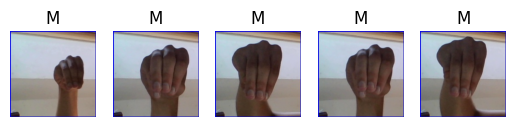

In [14]:
# Printing 5 random images from any training category or from a specified category
%matplotlib inline

import cv2
import os
import random
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

number_of_rows = 1
number_of_columns = 5

categories = os.listdir(TRAINING_DIR)

random.seed(13)

category = random.choice(categories)

# category = 'A'

for i in range(number_of_columns):
  subplot = plt.subplot(number_of_rows, number_of_columns, i + 1)
  subplot.axis('Off')
  subplot.set_title(category)
  image_path = os.path.join(
      TRAINING_DIR,
      str(category),
      str(category) + str(random.randint(1, 1000)) + '.jpg'
  )
  image = mpimg.imread(image_path)
  plt.imshow(image)

plt.show()

# Preparing the training set

**Augmenting the data with brightness and zoom ranges:**

In [15]:
print(os.listdir(TRAINING_DIR)[:5])


['del', 'P', 'I', 'U', 'X']


In [16]:
# Preparing ImageDataGenerator object for training the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = 200
BATCH_SIZE = 64

data_generator = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=[0.8, 1.0],
    zoom_range=[1.0, 1.2],
    validation_split=0.1
)

train_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="training")

validation_generator = data_generator.flow_from_directory(TRAINING_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=13,
                                                     class_mode='categorical', batch_size=BATCH_SIZE, subset="validation")

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


# Preparing the model for training

**Downloading custom weight file if required:**

In [17]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2025-11-17 19:19:26--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.99.207, 142.250.107.207, 74.125.20.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.99.207|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-11-17 19:19:26 ERROR 403: Forbidden.



**Preparing Inception V3 Network for transfer learning:**

In [18]:
# Loading inception v3 network for transfer learning
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.applications.inception_v3 import InceptionV3

WEIGHTS_FILE = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

inception_v3_model = InceptionV3(
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top = False,
    weights = 'imagenet'
)

# Not required --> inception_v3_model.load_weights(WEIGHTS_FILE)

# Enabling the top 2 inception blocks to train
for layer in inception_v3_model.layers[:249]:
    layer.trainable = False

for layer in inception_v3_model.layers[249:]:
    layer.trainable = True


# Checking model summary to pick a layer (if required)
inception_v3_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 99, 99,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 99, 99,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 99, 99,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 97, 97,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 97,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 97, 97,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 97, 97,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 97,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 97, 97,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 46, 46,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 46,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 46, 46,    │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 11,114,880 (42.40 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

**Choosing the inception output layer:**

In [19]:
# Choosing the output layer to be merged with our FC layers (if required)
inception_output_layer = inception_v3_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

# Not required --> inception_output = inception_output_layer.output
inception_output = inception_v3_model.output

AttributeError: 'Concatenate' object has no attribute 'output_shape'

**Adding our own set of fully connected layers at the end of Inception v3 network:**

In [21]:
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras import layers, Model

x = layers.GlobalAveragePooling2D()(inception_v3_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.3)(x)
# Not required --> x = layers.Dropout(0.2)(x)
x = layers.Dense(29, activation='softmax')(x)

model = Model(inputs=inception_v3_model.input, outputs=x)

model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['acc']
)

**Looking at the final model:**

In [23]:
# Watch the new model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 99, 99,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 99, 99,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 99, 99,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 97, 97,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 97,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 97, 97,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 97, 97,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 97, 97,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 97, 97,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 46, 46,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 46,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 46, 46,    │          0 │ batch_normalizat

 Total params: 23,930,685 (91.29 MB)

 Trainable params: 13,242,781 (50.52 MB)

 Non-trainable params: 10,687,904 (40.77 MB)

**Setting up a callback funtion in order to stop training at a particular threshold:**

In [25]:
# Creating a callback to stop model training after reaching a threshold accuracy

LOSS_THRESHOLD = 0.2
ACCURACY_THRESHOLD = 0.95

class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_loss') <= LOSS_THRESHOLD and logs.get('val_acc') >= ACCURACY_THRESHOLD:
      print("\nReached", ACCURACY_THRESHOLD * 100, "accuracy, Stopping!")
      self.model.stop_training = True

callback = ModelCallback()

# Training the model generated using Inception v3 and our own set of Fully Connected layers

**Fitting the model to the training dataset:**

In [27]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=100,
    validation_steps=50,
    epochs=50,
    callbacks=[callback]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - acc: 0.0412 - loss: 3.4998 - val_acc: 0.0644 - val_loss: 3.3824
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - acc: 0.0818 - loss: 3.2834 - val_acc: 0.1163 - val_loss: 3.2208
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - acc: 0.1727 - loss: 3.0982 - val_acc: 0.1956 - val_loss: 3.1099
Epoch 4/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - acc: 0.2502 - loss: 2.9279 - val_acc: 0.2428 - val_loss: 3.0248
Epoch 5/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - acc: 0.3304 - loss: 2.7588 - val_acc: 0.2922 - val_loss: 2.9220
Epoch 6/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.4021 - loss: 2.5799 - val_acc: 0.3394 - val_loss: 2.8151
Epoch 7/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.4453 - loss: 2.4341 - val_acc: 0.3759 - val_loss: 2.7208
Epoch 8/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.5059 - loss: 2.2642 - val_acc: 0.4116 - val_loss: 2.6282
Epoch 9/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 415ms/step - acc: 0.6705 - loss: 1.6319 - val_acc: 0.5344 - val_loss: 2.1545
Epoch 14/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - acc: 0.6815 - loss: 1.5622 - val_acc: 0.5744 - val_loss: 2.0235
Epoch 15/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - acc: 0.7140 - loss: 1.4538 - val_acc: 0.5766 - val_loss: 1.9484
Epoch 16/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.7134 - loss: 1.3783 - val_acc: 0.5966 - val_loss: 1.8516
Epoch 17/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - acc: 0.7545 - loss: 1.2505 - val_acc: 0.6309 - val_loss: 1.7086
Epoch 18/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.7598 - loss: 1.1975 - val_acc: 0.6353 - val_loss: 1.6643
Epoch 19/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - acc: 0.7760 - loss: 1.1063 - val_acc: 0.6656 - val_loss: 1.5297
Epoch 20/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - acc: 0.8018 - loss: 1.0205 - val_acc: 0.6669 - val_loss: 1.4793
Epoch 21/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/s

# Plotting the results

**Training Accuracy vs Validation Accuracy:**

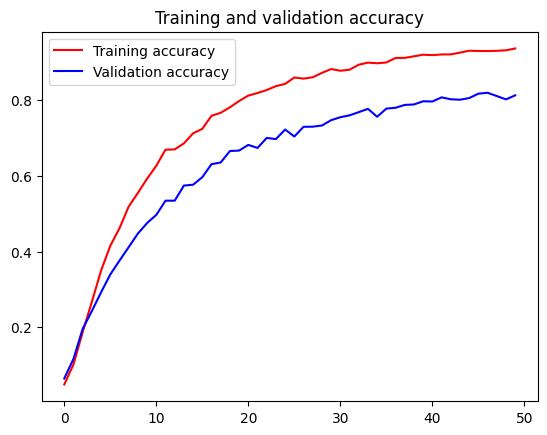

<Figure size 640x480 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

**Training Loss vs Validation Loss**

<Figure size 640x480 with 0 Axes>

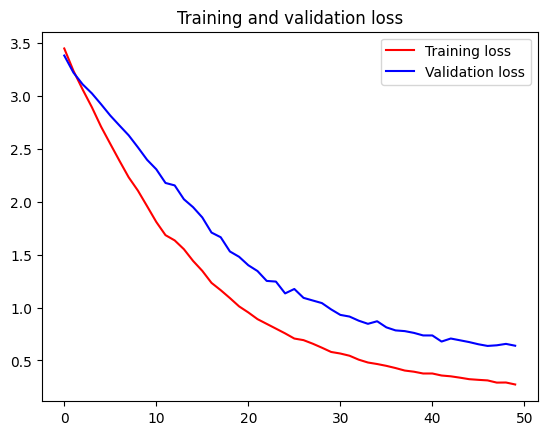

<Figure size 640x480 with 0 Axes>

In [30]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()

# Saving the model

**As we were satisfied with our results we save our model:**

In [31]:
# Saving the model
MODEL_NAME = 'models/asl_alphabet_{}.h5'.format(9575)
model.save(MODEL_NAME)

# Testing our model

**Plotting images along with their respective actual and predicted classes:**

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Actual class: G 
 Predicted class: G


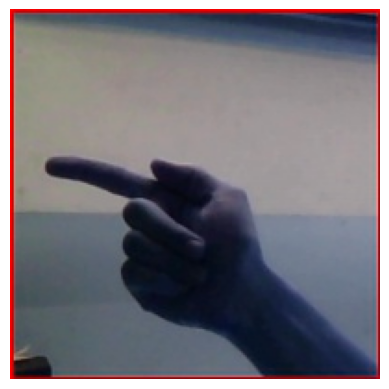

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Actual class: J 
 Predicted class: J


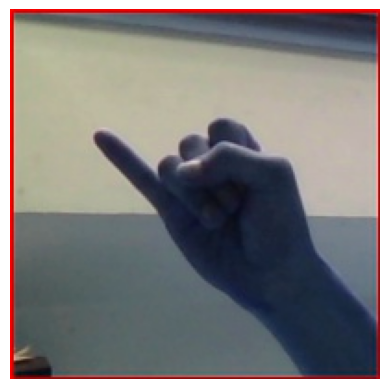

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Actual class: T 
 Predicted class: T


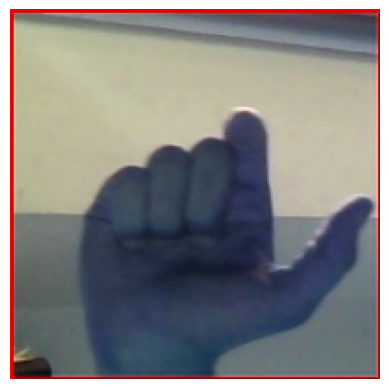

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Actual class: P 
 Predicted class: P


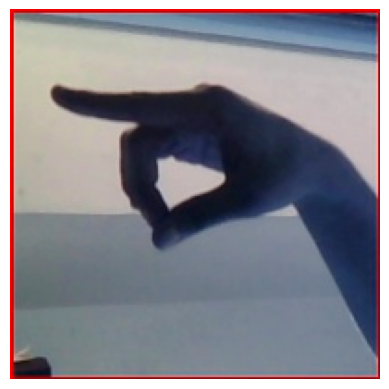

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Actual class: V 
 Predicted class: V


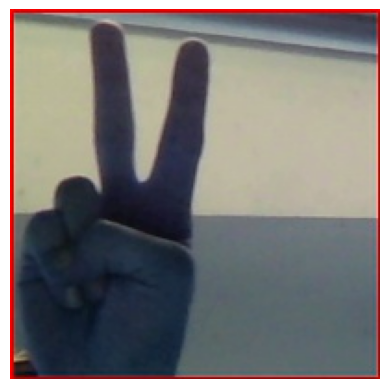

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Actual class: C 
 Predicted class: C


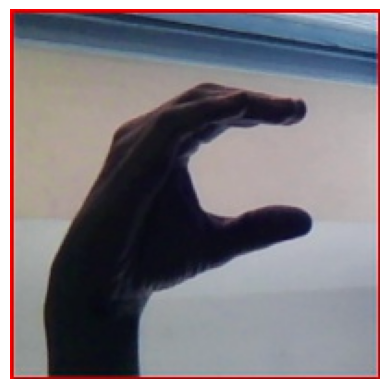

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Actual class: B 
 Predicted class: B


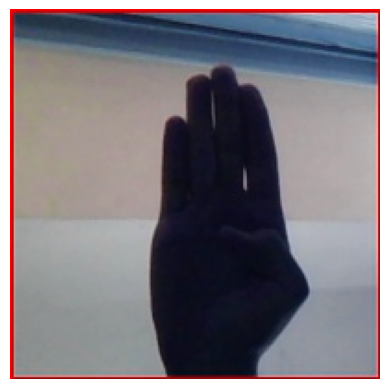

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Actual class: space 
 Predicted class: space


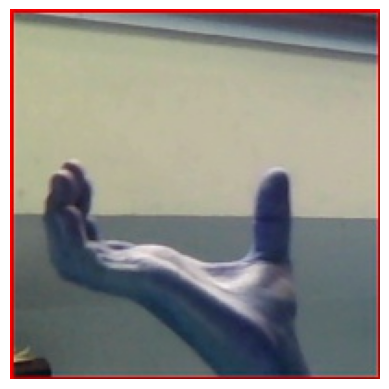

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Actual class: U 
 Predicted class: U


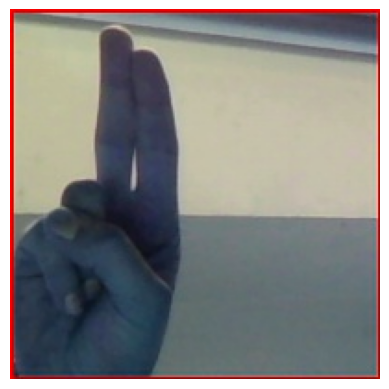

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Actual class: O 
 Predicted class: O


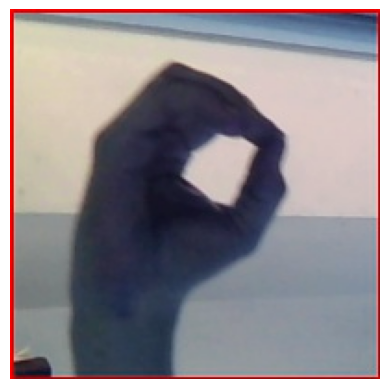

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Actual class: E 
 Predicted class: E


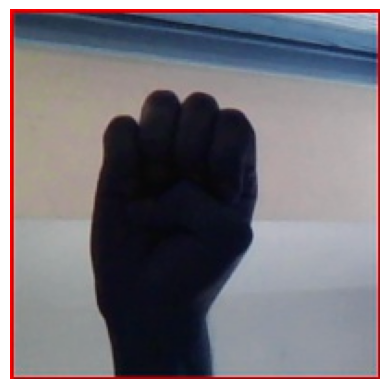

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Actual class: Z 
 Predicted class: Z


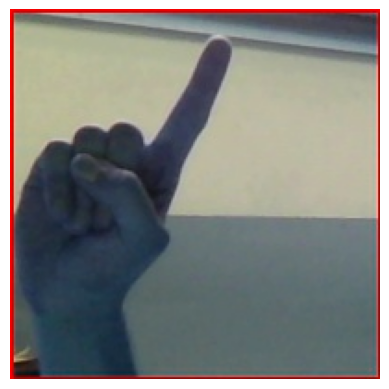

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Actual class: F 
 Predicted class: F


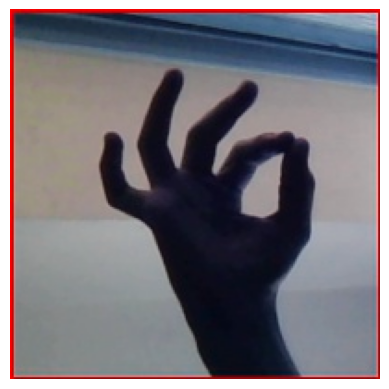

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Actual class: Q 
 Predicted class: Q


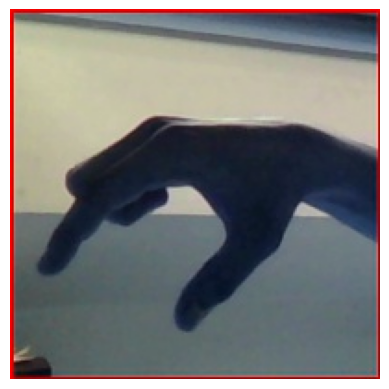

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Actual class: I 
 Predicted class: I


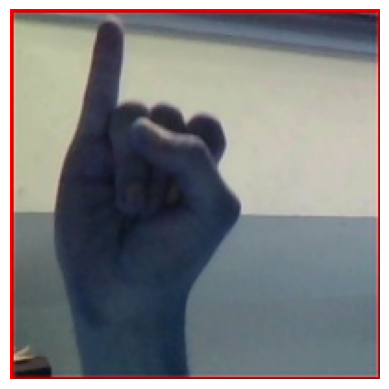

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Actual class: H 
 Predicted class: H


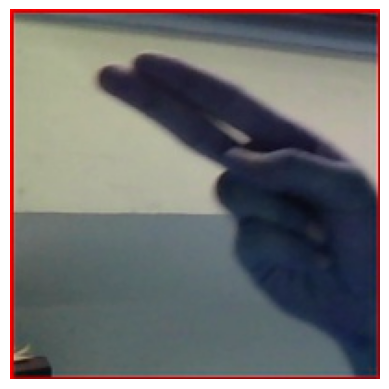

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Actual class: A 
 Predicted class: A


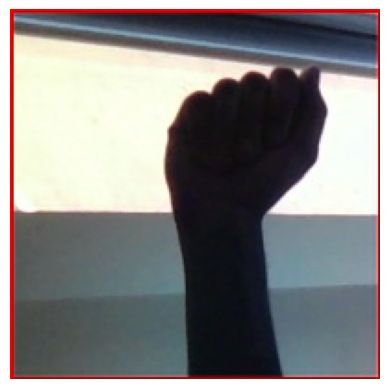

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Actual class: Y 
 Predicted class: Y


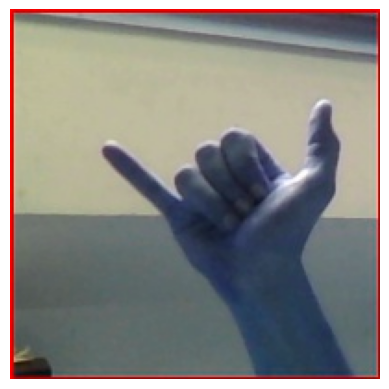

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Actual class: D 
 Predicted class: D


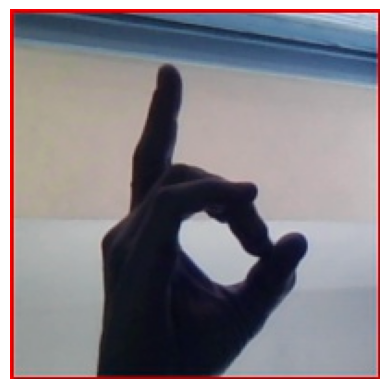

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Actual class: R 
 Predicted class: R


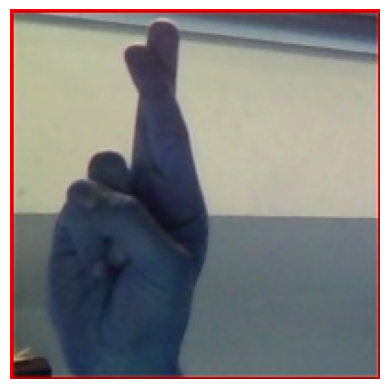

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Actual class: S 
 Predicted class: S


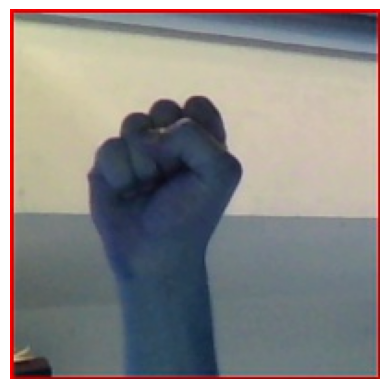

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Actual class: L 
 Predicted class: L


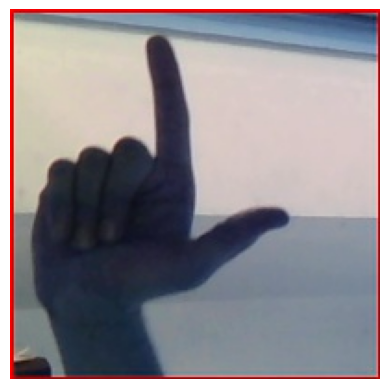

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Actual class: nothing 
 Predicted class: nothing


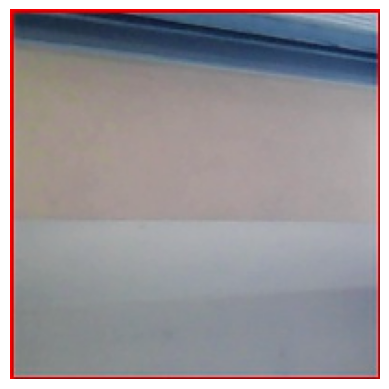

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Actual class: M 
 Predicted class: M


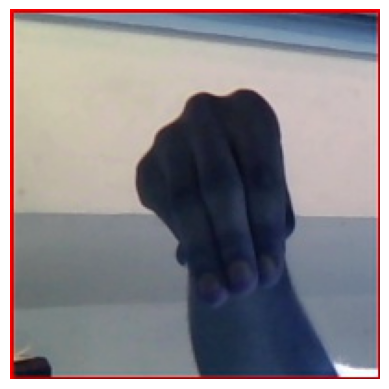

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Actual class: W 
 Predicted class: W


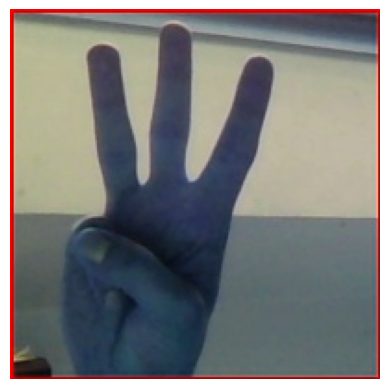

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Actual class: X 
 Predicted class: X


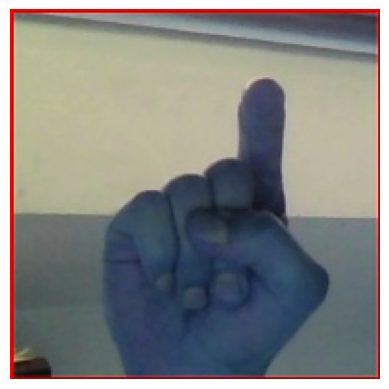

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Actual class: K 
 Predicted class: V


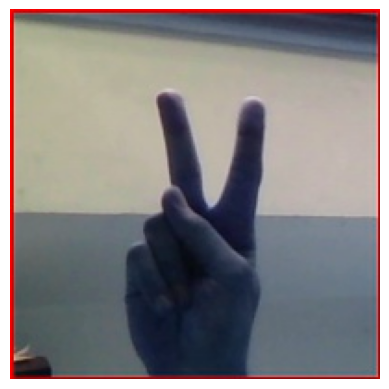

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Actual class: N 
 Predicted class: N


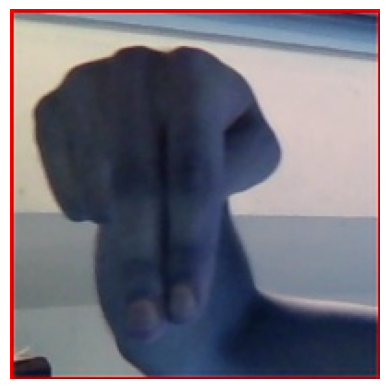

In [32]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

classes = os.listdir(TRAINING_DIR)
classes.sort()

for i, test_image in enumerate(os.listdir(TEST_DIR)):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    plt.figure()
    plt.axis('Off')
    plt.imshow(img)
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} \n Predicted class: {}'.format(actual, predicted))
    plt.show()

**Calculating test accuracy:**

In [33]:
test_images = os.listdir(TEST_DIR)
total_test_cases = len(test_images)
total_correctly_classified = 0
total_misclassified = 0
for i, test_image in enumerate(test_images):
    image_location = TEST_DIR + test_image
    img = cv2.imread(image_location)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = np.array(img) / 255.
    img = img.reshape((1, IMAGE_SIZE, IMAGE_SIZE, 3))
    img = data_generator.standardize(img)
    prediction = np.array(model.predict(img))
    actual = test_image.split('_')[0]
    predicted = classes[prediction.argmax()]
    print('Actual class: {} - Predicted class: {}'.format(
        actual, predicted), end=' ')
    if actual == predicted:
      print('PASS!')
      total_correctly_classified += 1
    else:
      print('FAIL!')
      total_misclassified += 1
print("=" * 20)
test_accuracy = (total_correctly_classified / total_test_cases) * 100
test_error_rate = (total_misclassified / total_test_cases) * 100

print('Test accuracy (%):', test_accuracy)
print('Test error rate (%):', test_error_rate)
print('Number of misclassified classes:', total_misclassified)
print('Number of correctly classified classes', total_correctly_classified)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Actual class: G - Predicted class: G PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Actual class: J - Predicted class: J PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Actual class: T - Predicted class: T PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Actual class: P - Predicted class: P PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Actual class: V - Predicted class: V PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Actual class: C - Predicted class: C PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Actual class: B - Predicted class: B PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Actual class: space - Predicted class: space PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Actual class: U - Predicted class: U PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Actual class: O - Predicted class: O PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Actual class: E - Predicted class: E PASS!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Actual class: Z - Predicted class: Z PASS!
1/1 ━━━━━━━━━━━━━━━━